In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
from pygimli.physics import ert
import meshop
import coupleinvfun as CF
import pygimli.physics.traveltime as tt
import petrorelationship as petroship
import matplotlib.pylab as pylab
from kill import kill
from IPython.display import clear_output  

params = {'legend.fontsize': 15,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 14,
         'axes.titlesize':14,
         'xtick.labelsize':14,
         'ytick.labelsize':14}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

## Seismic inversion

you can skip it, if you alrealy have structure information

In [2]:
ttData = tt.load("ttData")
print(ttData)

Data: Sensors: 90 data: 1424, nonzero entries: ['err', 'g', 's', 't', 'valid']


18/10/22 - 22:42:10 - pyGIMLi - INFO - Found 2 regions.
18/10/22 - 22:42:10 - pyGIMLi - INFO - Region with smallest marker (1) set to background
18/10/22 - 22:42:10 - pyGIMLi - INFO - Creating forward mesh from region infos.


Data: Sensors: 90 data: 1305, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'rhoa', 'valid']


18/10/22 - 22:42:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Mesh: Nodes: 1731 Cells: 3181 Boundaries: 4911


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x196b64c24c0>)

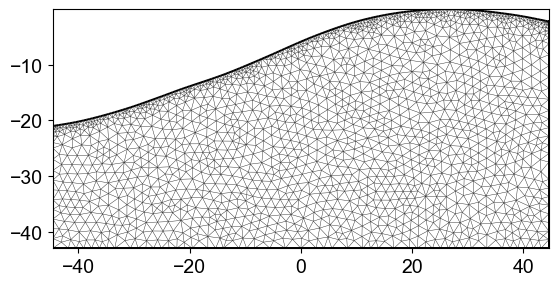

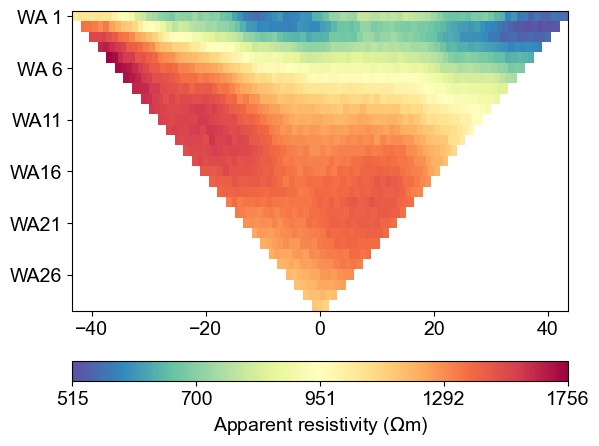

In [3]:
%matplotlib inline
ertData = ert.load('ertdata')
print(ertData)
ert1 = ert.ERTManager(ertData)
grid = ert1.createMesh(data=ertData,quality=31,paraDX=0.5, paraMaxCellSize=2, boundaryMaxCellSize=3000,smooth=[2, 2],
                       paraBoundary=0.1, paraDepth = 22.0)
ert1.setMesh(grid)
mesh = ert1.fop.paraDomain
mesh.setCellMarkers(np.ones((mesh.cellCount()))*2)
pg.show(mesh)
print(mesh)
ert.show(ertData)

18/10/22 - 22:42:11 - pyGIMLi - INFO - Found 1 regions.
18/10/22 - 22:42:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/10/22 - 22:42:11 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
18/10/22 - 22:42:11 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
18/10/22 - 22:42:11 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00176365 0.00140953 0.00147536 ... 0.00023777 0.00025435 0.00024498]
18/10/22 - 22:42:11 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x00000196B7A5EEA0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000196B6427130>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000196F8AB5A60>
min/max (data): 0.0013/0.03
min/max (error): 0.97%/1.04%
min/max (start model): 2.0e-04/0.002
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 312.08 (dPhi = 77.65%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 187.48 (dPhi = 39.79%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 109.57 (dPhi = 41.69%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 48.91 (dPhi = 53.33%) lam: 50.0
------

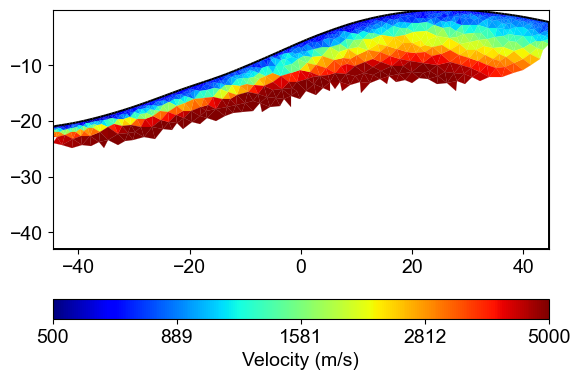

In [4]:
## 0.94
ttData = tt.load("ttData") # You can change the data file name
TT = pg.physics.traveltime.TravelTimeManager()
TT.setMesh(mesh)
TT.invert(ttData, lam=50,
          zWeight=0.2,vTop=500, vBottom=5000,
          verbose=1, limits=[100., 6000.])

ax, cbar = TT.showResult(cMap='jet',coverage=TT.standardizedCoverage(),cMin=500,cMax=5000)

In [ ]:
# generate a denser mesh
%matplotlib inline
geo = pg.meshtools.createParaMeshPLC(ertData, quality=34, paraMaxCellSize=0.1,
                                         paraBoundary=0.1,
                                         boundary=0, paraDepth = 22.0)

meshall = pg.meshtools.createMesh(geo,quality=34,area=0.03, smooth=[2, 2], paraBoundary=0.1)

out = meshop.linear_interpolation(TT.paraDomain, TT.model.array(), meshall)
out = out.array()
# out = meshop.nearest_neighbor_interpolation(TT.paraDomain, TT.model.array(), meshall)
# out = np.array(out)
Cvout= meshop.nearest_neighbor_interpolation(TT.paraDomain, TT.standardizedCoverage(), meshall)

pg.show(meshall,out,cMap='jet',coverage=Cvout,label='velocity')


In [ ]:
# Vinvmodel = np.load('Vinvmodel.npy')
# Vsensmodel = np.load('Vsensmodel.npy')
# pg.show(meshall,Vinvmodel,cMap='jet',coverage=Vsensmodel,label='velocity')
# out = Vinvmodel
# Cvout = Vsensmodel

## load seismic results
If you have the seismic inverted results, you can begin with here

In [ ]:
# meshall.save('velmesh')
# np.save('Vinvmodel',out)
# np.save('Vsensmodel',Cvout)
meshall = pg.load('velmesh.bms')
out = np.load('Vinvmodel.npy')
Cvout = np.load('Vsensmodel.npy')

In [ ]:
%matplotlib auto
pg.show(meshall,out,cMap='jet',coverage=Cvout,label='velocity')

In [ ]:
# set up the horizontal position and depth to see the velocity distribution
%matplotlib auto
Xpos = [26,27,28]
Depth =[-13,-13,-13]
xyzpos = CF.sepcificline(meshall,out,Xpos,Depth)

In [7]:
%matplotlib auto
# select the specific value to do the geophysical zonation
value1 = 1500
value2 = 3600

# set the sections and interval to automatically pick up boundary
firstarea_section = [-45,45]
secondarea_section = [-45,45]
interval = 1

Cvout = np.array(Cvout)
Cvout = np.ones(Cvout.shape)
# set the boundary interpolation range

nrangeinte = np.arange(ertData.sensors().array()[0][0],ertData.sensors().array()[-1][0],0.5)
nrangeinte = np.hstack((nrangeinte,ertData.sensors().array()[-1][0]))
loc1new,loc2new = CF.boundary(out,Cvout,xyzpos,value1,value2,firstarea_section,secondarea_section,interval,nrangeinte)

Using matplotlib backend: QtAgg


In [8]:
np.save('linex',nrangeinte)
np.save('line1',loc1new)
np.save('line2',loc2new)

In [10]:
markerall,meshafter = CF.constraintinvpara(ertData,nrangeinte,loc1new,loc2new,paraBoundary=0.3)
pg.show(meshafter,markerall)
np.save('markerall',markerall)

In [16]:
#25
ertData['err'] = ert1.estimateError(ertData, 
                                absoluteUError=0.0000, # 50µV
                                relativeError=0.01)  # 3%

# do the contrained inversion
mgrConstrained = ert.ERTManager()
mgrConstrained.invert(data=ertData, verbose=True, lam=50, mesh=meshafter,limits=[10., 10000.])


# do the uncontrained inversion for comparison
mgrnoConstrained = ert.ERTManager()
mgrnoConstrained.invert(data=ertData, lam=50, paraDepth = 22.0,
                         paraDX=0.5, paraMaxCellSize=5, verbose=True,paraBoundary=0.3,limits=[10., 10000.])


02/06/22 - 22:00:42 - pyGIMLi - INFO - Found 2 regions.
02/06/22 - 22:00:42 - pyGIMLi - INFO - Region with smallest marker (1) set to background
02/06/22 - 22:00:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
02/06/22 - 22:00:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
02/06/22 - 22:00:42 - pyGIMLi - INFO - Use median(data values)=1201.31244703223
02/06/22 - 22:00:42 - pyGIMLi - INFO - Created startmodel from forward operator: 4546 [1201.31244703223,...,1201.31244703223]
02/06/22 - 22:00:42 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002356D8CEAE0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002356D8CE9A0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002355A2A9F40>
min/max (data): 515/1756
min/max (error): 1%/1%
min/max (start model): 1201/1201
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 22.51 (dPhi = 34.69%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 17.6 (dPhi = 21.83%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 8.65 (dPhi = 50.14%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.15 (dPhi = 84.11%) lam: 50.0
---------------------------------------

02/06/22 - 22:02:54 - pyGIMLi - INFO - Found 2 regions.
02/06/22 - 22:02:54 - pyGIMLi - INFO - Region with smallest marker (1) set to background
02/06/22 - 22:02:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
02/06/22 - 22:02:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
02/06/22 - 22:02:54 - pyGIMLi - INFO - Use median(data values)=1201.31244703223
02/06/22 - 22:02:54 - pyGIMLi - INFO - Created startmodel from forward operator: 2059 [1201.31244703223,...,1201.31244703223]
02/06/22 - 22:02:54 - pyGIMLi - INFO - Starting inversion.


chi² = 0.91 (dPhi = 9.29%) lam: 50.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002355BF17540>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002356D8CE900>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002355BFA1640>
min/max (data): 515/1756
min/max (error): 1%/1%
min/max (start model): 1201/1201
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 18.21 (dPhi = 42.85%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 14.28 (dPhi = 20.34%) lam: 50.0
------------------------

2059 [661.6352082619281,...,2180.012924018446]

(<AxesSubplot:xlabel='x (m)', ylabel='z (m)'>,
 <matplotlib.colorbar.Colorbar at 0x235629af460>)

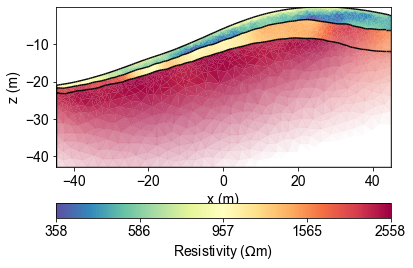

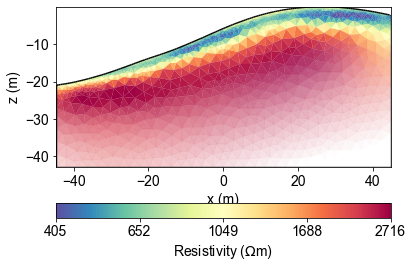

In [17]:
%matplotlib inline
mgrConstrained.showResult(xlabel="x (m)", ylabel="z (m)",coverage = mgrConstrained.coverage())
mgrnoConstrained.showResult(xlabel="x (m)", ylabel="z (m)",coverage = mgrnoConstrained.coverage())


In [18]:
print(np.mean(abs(mgrConstrained.inv.response-mgrConstrained.inv.dataVals)/mgrConstrained.inv.dataVals))

0.007491179385364574


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x2355ddbc7f0>)

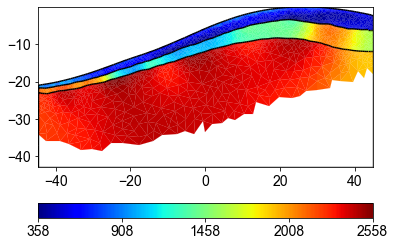

In [19]:
%matplotlib inline
Mall = np.array(mgrConstrained.paraModel())
sens = mgrConstrained.coverage()
mgrConstrained.paraDomain.save('constaintmesh')
np.save('constaintmodel',Mall )
np.save('constaintsens',sens)
sens[sens<-1.3]=-10000
# pg.show(mgrConstrained.paraDomain,sens,cMap='jet')
pg.show(mgrConstrained.paraDomain,Mall,cMap='jet',coverage=sens)


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x2355dc69220>)

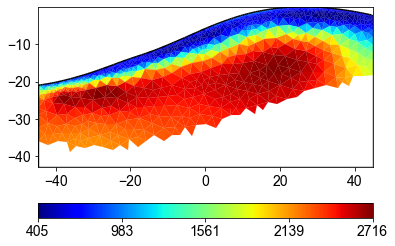

In [20]:
%matplotlib inline
Mall2 = np.array(mgrnoConstrained.paraModel())
sens2 = mgrnoConstrained.coverage()
mgrnoConstrained.paraDomain.save('noconstaintmesh')
np.save('noconstaintmodel',Mall2)
np.save('noconstaintsens',sens2)
np.save('markerall',markerall)
sens2[sens2<-1.3]=-10000
# pg.show(mgrnoConstrained.paraDomain,sens2,cMap='jet')
pg.show(mgrnoConstrained.paraDomain,Mall2,cMap='jet',coverage=sens2)


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x2356dafc100>)

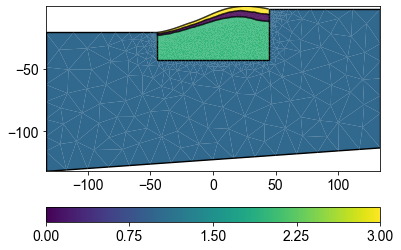

In [21]:
pg.show(meshafter,markerall)

## MC sampling for water content

You can start directly here if you already have resistivity inversion results

In [2]:
noconstaintmesh = pg.load('noconstaintmesh.bms')
noconstaintmodel = np.load('noconstaintmodel.npy')
noconstaintsens = np.load('noconstaintsens.npy')

constaintmesh = pg.load('constaintmesh.bms')
constaintmodel = np.load('constaintmodel.npy')
constaintsens = np.load('constaintsens.npy')

In [3]:
markerall = np.load('markerall.npy')

In [4]:
markerall.shape

(5353,)

In [5]:
print(constaintmesh.cellCount())

markerall2 = markerall[markerall!=1].copy()
markerall2.shape

4546


(4546,)

In [6]:
markerall2==3

array([False, False, False, ..., False, False, False])

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x244e4cf6550>)

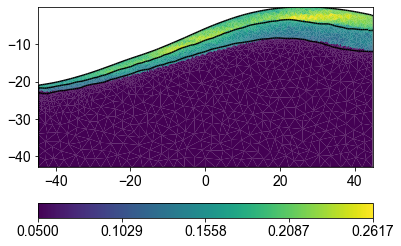

In [13]:
synmesh = pg.load('synmesh.bms')
synporosity = np.load('synporosity.npy')
synSat = np.load('synSat.npy')

synmoisture =  meshop.nearest_neighbor_interpolation(synmesh, synSat*synporosity, constaintmesh)
synmoisture = np.array(synmoisture)
pg.show(constaintmesh,synmoisture)

In [19]:
# import the packages
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp


morris_problem = {
    'num_vars': 10,
    # These are their names
    'names': ['rhos1', 'rhos2', 'rhos3',
             'porosity1','porosity2','porosity3',
              'n_model1','n_model2','n_model3',
             'sigmas'], # can add z1 z2 etc.
    # Plausible ranges over which we'll move the variables
    'bounds': [[80,400], 
               [600,1200],
               [1800,2800],
               [0.25,0.5],
               [0.12,0.25],
               [0.01,0.08],
               [1.8,2.5],
               [1.6,2.0],
               [2.4,2.6],
               [1/3200,1/400],
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

In [53]:
sample = ms.sample(morris_problem, 900, num_levels=10)
sample.shape

(9900, 10)

In [56]:
def petroMC(iter1,modnum,petrorange,markerall,Mall,sample):
    import petrorelationship as petroship
    import random

    markerall2 = np.zeros((1,modnum))
    markerall2 = markerall[markerall!=1].copy()

    modelsall = np.zeros((iter1,modnum))
    modelsall2 = np.zeros((iter1,modnum))
    #sample = np.zeros((iter1,10))
    
    for i in range(iter1):
        
        pro1,pro2,pro3 = sample[i,0:3]
        pro1=random.uniform(petrorange.rhos[0], petrorange.rhos[1])
        pro2=random.uniform(petrorange.rhos[2], petrorange.rhos[3])
        pro3=random.uniform(petrorange.rhos[4], petrorange.rhos[5])       
        rhos2 = petroship.proassign(markerall2,
                                           pro1=pro1,
                                           pro2=pro2,
                                           pro3=pro3) 
        
        
        pro1,pro2,pro3 = sample[i,3:6]

                
        porosity2 = petroship.proassign(markerall2,
                                        pro1=pro1,
                                        pro2=pro2,
                                        pro3=pro3)
        
        pro1,pro2,pro3 = sample[i,6:9]

        
        #print(porosity2)
        n_model2 = petroship.proassign(markerall2,
                                       pro1=pro1,
                                       pro2=pro2,
                                       pro3=pro3)
        pro1 = sample[i,9]

        sigmas2 = petroship.proassign(markerall2,
                                           pro1=pro1,
                                           pro2=random.uniform(petrorange.sigmas[2], petrorange.sigmas[3]),
                                           pro3=random.uniform(petrorange.sigmas[4], petrorange.sigmas[5]))
                                           
       #sample[i,9] = pro1
                                           
        mod = Mall
        
        #### make true the sigma > 0
        tempsigmas2 = sigmas2[markerall2==3].copy()
        temprhos2 = rhos2[markerall2==3].copy()
        
        delta_value = 1/temprhos2- tempsigmas2
        minsigmas2 = np.min([petrorange.sigmas[0],petrorange.sigmas[1]])
        
        tempsigmas2[delta_value<=0] = np.random.uniform(minsigmas2,1/temprhos2[delta_value<=0])
        
        sigmas2[markerall2==3] = tempsigmas2
        
        ##### only change regolith 
        rhos2[markerall2==3] = 1/(1/rhos2[markerall2==3] - sigmas2[markerall2==3])
        
        #print(sigmas2.shape)
        S_2_rho = petroship.InvArchieSrhos2(rho=mod,rhos=rhos2, n=n_model2, a=petrorange.a_model,sigma_sur=sigmas2)
        #print(S_2_rho.shape)
        #S_2_rho = petroship.InvArchieSrhos(rho=mod,rhos = rhos2, n = n_model2, a=petrorange.a_model,sigmas=sigmas2)
        modelsall[i] = S_2_rho*porosity2
        modelsall2[i] = porosity2

    return modelsall, modelsall2



In [57]:
petrorange = petroship.petrorange
# petrorange.porosity = [0.45, 0.3, 0.1, 0.35, 0.02, 0.1]
# petrorange.m_model = [1.4, 2.2, 1.0, 1.5, 1.6, 2.5]
#petrorange.m_model = [2.5, 1.8, 1.6, 2.0, 2.4, 2.6]

petrorange.porosity = [0.5, 0.25, 0.25, 0.12, 0.08, 0.01]
petrorange.rhos = [80, 400, 600, 1200, 1800, 2800]
petrorange.sigmas = [1/400, 1/3200, 0, 0, 0, 0]

petrorange.n_model = [2.5, 1.8, 1.6, 2.0, 2.4, 2.6]
petrorange.a_model = 1.0

iter1 = len(sample)

modelsall,modelsall2 = petroMC(iter1, constaintmesh.cellCount(),
           petrorange,markerall,constaintmodel,sample)






In [58]:
modelsall.shape
sample.shape

(9900, 10)

In [68]:
constaintsens

array([-0.2806773 ,  0.11395217, -0.26905159, ..., -2.0580835 ,
       -2.04827149, -2.12446045])

In [69]:
def obj_fun(sim,obs):
    y = sim-obs   
    y = np.sqrt(np.mean(y**2))
    return y

output = np.zeros((1,len(sample)))
idd = constaintsens>-1.3
for ii in range(0, len(sample)):
    output[0,ii] = obj_fun(modelsall[ii,idd ],synmoisture[idd])  
    
    
output2 = np.zeros((1,len(sample)))
for ii in range(0, len(sample)):
    output2[0,ii] = np.mean(modelsall[ii,:])

In [60]:
output.shape

(1, 9900)

In [61]:
Si = ma.analyze(morris_problem, sample, output, print_to_console=False)

In [70]:
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mean(EE)", "mean(|EE|)", "std(EE)"))
for name, s1, st, mean in zip(morris_problem['names'],
                              Si['mu'],
                              Si['mu_star'],
                              Si['sigma']):
    print("{:20s} {:=7.6f} {:=7.6f} {:=7.6f}".format(name, s1, st, mean))

Name                 mean(EE) mean(|EE|) std(EE)
rhos1                0.000793 0.022745 0.028548
rhos2                -0.001286 0.024517 0.030324
rhos3                -0.004331 0.026367 0.060478
porosity1            0.034120 0.037848 0.029724
porosity2            0.025915 0.032352 0.029811
porosity3            0.025485 0.033464 0.081720
n_model1             0.010637 0.023999 0.028173
n_model2             0.002542 0.024191 0.030205
n_model3             0.000247 0.024586 0.042807
sigmas               -0.006398 0.023319 0.028149


In [67]:
Si = ma.analyze(morris_problem, sample, output2, print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mean(EE)", "mean(|EE|)", "std(EE)"))
for name, s1, st, mean in zip(morris_problem['names'],
                              Si['mu'],
                              Si['mu_star'],
                              Si['sigma']):
    print("{:20s} {:=7.6f} {:=7.6f} {:=7.6f}".format(name, s1, st, mean))

Name                 mean(EE) mean(|EE|) std(EE)
rhos1                0.000793 0.022745 0.028548
rhos2                -0.001286 0.024517 0.030324
rhos3                -0.004331 0.026367 0.060478
porosity1            0.034120 0.037848 0.029724
porosity2            0.025915 0.032352 0.029811
porosity3            0.025485 0.033464 0.081720
n_model1             0.010637 0.023999 0.028173
n_model2             0.002542 0.024191 0.030205
n_model3             0.000247 0.024586 0.042807
sigmas               -0.006398 0.023319 0.028149


In [ ]:
tradmodelsall,tradmodelsall2 = CF.petroMCtt(iter1,noconstaintmesh.cellCount(),petrorange,noconstaintmodel)

In [8]:
modelsall.shape

(10000, 4546)

0.037929286301219355


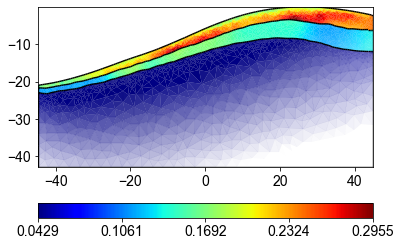

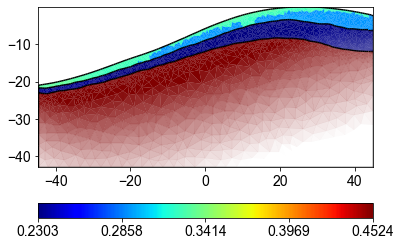

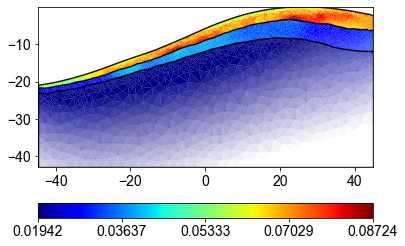

In [9]:
pg.show(constaintmesh,np.mean(modelsall,axis=0),cMap='jet',coverage=constaintsens)
pg.show(constaintmesh,np.std(modelsall,axis=0)/np.mean(modelsall,axis=0),cMap='jet',coverage=constaintsens)
pg.show(constaintmesh,np.std(modelsall,axis=0),cMap='jet',coverage=constaintsens)
print(np.mean(np.std(modelsall,axis=0)))
np.mean(np.std(modelsall,axis=0)/np.mean(modelsall,axis=0))
np.save('constaintWC',modelsall)

0.046099606877570344


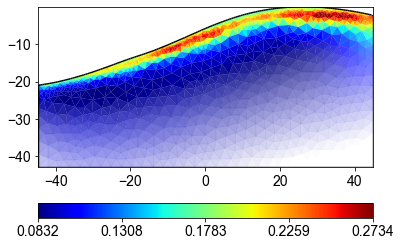

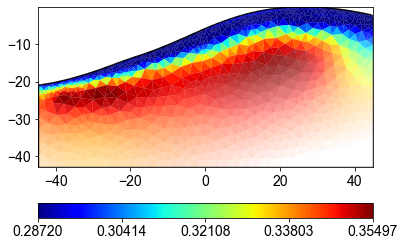

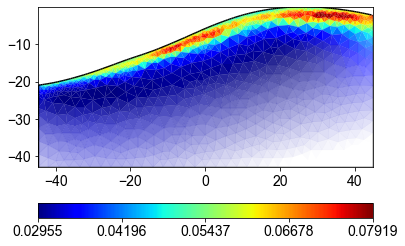

In [10]:
pg.show(noconstaintmesh,np.mean(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
pg.show(noconstaintmesh,np.std(tradmodelsall,axis=0)/np.mean(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
pg.show(noconstaintmesh,np.std(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
print(np.mean(np.std(tradmodelsall,axis=0)))
np.mean(np.std(tradmodelsall,axis=0)/np.mean(tradmodelsall,axis=0))
np.save('noconstaintWC',tradmodelsall)

In [42]:
#np.save('noconstaintWC',tradmodelsall)